
**Created by:**

__Viktor Varga__

<br>

<img src="https://docs.google.com/uc?export=download&id=1q8cQBQKSLqS3PirWEmtQyObewgHOVISl" style="display:inline-block" width='40%'>
<hr>

# Logisztikus regresszió gradiens módszerrel

Az adatbázisok forrása: http://www.dcc.fc.up.pt/~ltorgo/Regression/DataSets.html

Importok.

In [ ]:
import numpy as np
import urllib
import urllib.request

import matplotlib.pyplot as plt

Feature scaling metódusok: egy az átlag és a szórás feature-önkénti számolására, majd a minta ezekkel történő normalizálására és egy másik ami már számolt átlag és szórás alapján normalizál egy mintát.

In [ ]:
def std_normalization(data):
    # params: data: ndarray(n_samples, n_features)
    data = np.asarray(data, dtype=np.float64)
    eps = 0.0000001
    x_mean = np.mean(data, axis=0)
    x_std = np.std(data, axis=0)
    x_norm = (data-x_mean) / (x_std + eps)

    return x_norm, x_mean, x_std

def std_normalize_with_given_meanstd(data, x_mean, x_std):
    eps = 0.0000001
    x_norm = (data-x_mean) / (x_std + eps)
    return x_norm

Adatbetöltés ("Breast Cancer Wisconsin (Diagnostic) Data Set" from the UCI ML repository).

**Feladat:** Daganatos páciensek diagnosztikai adatai alapján becsüljük meg, hogy jó-, vagy rosszindulatú-e a daganatuk.

In [ ]:
url = 'https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/wdbc.data'

ftpstream = urllib.request.urlopen(url)
content_cl = ftpstream.read().decode('utf-8')

Adatfeldolgozás: text fájlból numpy tömb.

In [ ]:
lines = content_cl.split('\n')
words = [line.split(',') for line in lines]
data = words[:-1]

features = [[float(item) for item in rec[2:]] for rec in data]
features = np.array(features, dtype=np.float32)

label_str_to_num = lambda label: 1. if label == 'M' else 0.
labels = [label_str_to_num(rec[1]) for rec in data]
labels = np.array(labels, dtype=np.float32)

# removing records with missing features (if any feature == 0.)
missing_features = np.any(features == 0., axis=1)
features = features[~missing_features,:]
labels = labels[~missing_features]

print(features.shape)
print(labels.shape)

(556, 30)
(556,)


X, Y kiválasztása, tanító és teszt halmaz szétválasztása.

In [ ]:
test_set_offset = int(features.shape[0]/2)
X_train = features[:test_set_offset]
y_train = labels[:test_set_offset]
X_test = features[test_set_offset:]
y_test = labels[test_set_offset:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(278, 30)
(278,)
(278, 30)
(278,)


Logisztikus regresszió osztály.

In [ ]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=10000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.eps = 0.00000001

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z) + self.eps)

    def __loss(self, h, y):
        return (-y * np.log(h + self.eps) - (1 - y) * np.log(1 - h + self.eps)).mean()

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # weights initialization
        self.theta = np.zeros(X.shape[1])

        loss_vals = []
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient

            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            loss = self.__loss(h, y)
            loss_vals.append(loss)

        return loss_vals

    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.theta))

    def predict(self, X):
        return self.predict_prob(X).round()

Feature scaling.

In [ ]:
X_train_n, x_mean, x_std = std_normalization(X_train)
X_test_n = std_normalize_with_given_meanstd(X_test, x_mean, x_std)

Tanítás és kiértékelés.

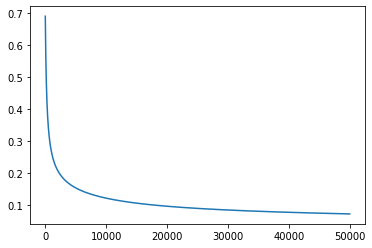

Training accuracy: 0.9748201438848921
Test accuracy: 0.9676258992805755


In [ ]:

#     if features are not scaled to same magnitude higher learning rate causes big fluctuations
#model = LogisticRegression(lr=0.00001, num_iter=50000)

model = LogisticRegression(lr=0.001, num_iter=50000)

loss = model.fit(X_train_n, y_train)

plt.plot(loss)
plt.show();

preds_train = model.predict(X_train_n)
print("Training accuracy: " + str((preds_train == y_train).mean()))
preds_test = model.predict(X_test_n)
print("Test accuracy: " + str((preds_test == y_test).mean()))

**Konklúzió:** Az egyszerű logisztikus regresszió meglepően jól teljesített: a teszthalmazon közel 97%-os arányban találta el, hogy az adott páciens daganata rosszindulatú-e, vagy sem. Bár a fenti kódban ez nem történt meg, de érdemes megvizsgálni, hogy valóban jó-e ez az eredmény. Ha ugyanis a címkék eloszlása nem közel egyenletes, akkor hiába a magas találati arány, a modell mégsem feltétlenül jó. Például, ha az adatbázisban szereplő páciensek 97%-a jóindulatú daganatos és csak a maradék 3%-nak van rosszindulatú daganata, egy triviális becsléssel is el tudunk érni 97%-os találati arányt (Pl. becsüljünk minden esetben konstans "jóindulatú" címkét függetlenül az inputtól).

Logisztikus regresszió több python könyvtárban már implementálva van. Egy implementáció (gradiensmódszer alapú és egyéb iteratív numerikus megoldásokkal) az sklearn csomagból:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html